<a href="https://colab.research.google.com/github/arjo31/malaria_detection/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import tensorflow_datasets as tfds
from keras import layers
from keras.models import Model
from keras.layers import Layer
from keras.metrics import TruePositives,TrueNegatives,FalsePositives,FalseNegatives,Precision,BinaryAccuracy,Precision,Recall,AUC
import sklearn
from sklearn.metrics import confusion_matrix

In [3]:
dataset, ds_info = tfds.load('malaria', with_info=True,as_supervised=True, shuffle_files=True, split=['train'])

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear i

In [5]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [6]:
dataset[0]

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [7]:
for data in dataset[0].take(5):
    print(data)

(<tf.Tensor: shape=(151, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(<tf.Tensor: shape=(121, 115, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
       

In [8]:
def splits(dataset, TRAIN_RATIO, TEST_RATIO, VALID_RATIO):
    dataset_size = len(dataset)

    train_dataset = dataset.take(int(TRAIN_RATIO*dataset_size))
    valid_test_dataset = dataset.skip(int(TRAIN_RATIO*dataset_size))
    valid_dataset = valid_test_dataset.take(int(VALID_RATIO*dataset_size))
    test_dataset  = valid_test_dataset.skip(int(VALID_RATIO*dataset_size))

    return train_dataset,valid_dataset,test_dataset


In [9]:
train, valid, test = splits(dataset[0],0.7, 0.2, 0.1)

In [10]:
list(train.take(1).as_numpy_iterator())

[(array([[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         ...,
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
  
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0],
          ...,
          [0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]], dtype=uint8),
  1)]

Data Visualization

In [11]:
train.take(5)

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

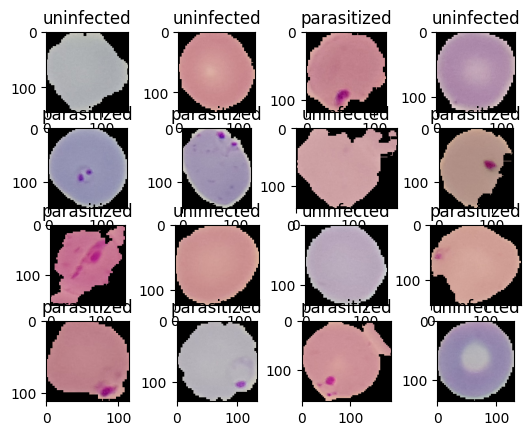

In [12]:
for i, (image, label) in enumerate(train.take(16)):
    # print("i = ", i)
    # print("image = ", image)
    # print("label = ", label)
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(ds_info.features['label'].int2str(label))

Data Processing

In [13]:
IMAGE_SIZE = 224
def resize_rescale(image,label):
    img = tf.image.resize(image, (IMAGE_SIZE,IMAGE_SIZE)) #Resize size must be of two elements in a tuple (new_height, new_width)
    return img/255.0, label

In [14]:
train = train.map(resize_rescale)
valid = valid.map(resize_rescale)
test = test.map(resize_rescale)

In [15]:
for data in train.take(1):
    print(data)

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)>, <tf.Tensor: shape=(), dtype=int6

In [16]:
train = train.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)
valid = valid.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

Model Creation (Sequential)

In [17]:
model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)),

    layers.Conv2D(filters = 5, kernel_size = 5, strides = 1 , padding = "valid", activation = 'sigmoid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides = 2),

    layers.Conv2D(filters =10, kernel_size = 5, strides = 1 , padding = "valid", activation = 'sigmoid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides = 2),

    layers.Flatten(),

    layers.Dense(100,activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(200, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(50, activation = 'relu'),
    layers.BatchNormalization(),

    layers.Dense(1, activation='sigmoid'),
])


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 5)       380       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 5)      20        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 5)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 10)      1260      
                                                                 
 batch_normalization_1 (Batc  (None, 106, 106, 10)     40        
 hNormalization)                                                 
                                                        

In [19]:
#Binary cross entropy loss formula = -(ylog p + (1-y)log(1-p)), where y = actual and p = prediction
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss = keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy']
              )

In [20]:
history = model.fit(train, validation_data = valid, epochs = 20, verbose = 1)

Epoch 1/20
603/603 [==============================] - 58s 68ms/step - loss: 0.4900 - accuracy: 0.7540 - val_loss: 0.8562 - val_accuracy: 0.7270
Epoch 2/20
603/603 [==============================] - 45s 75ms/step - loss: 0.2988 - accuracy: 0.8759 - val_loss: 1.3523 - val_accuracy: 0.7256
Epoch 3/20
603/603 [==============================] - 49s 81ms/step - loss: 0.2206 - accuracy: 0.9217 - val_loss: 0.4729 - val_accuracy: 0.8748
Epoch 4/20
603/603 [==============================] - 41s 67ms/step - loss: 0.2133 - accuracy: 0.9260 - val_loss: 0.4432 - val_accuracy: 0.8664
Epoch 5/20
603/603 [==============================] - 40s 67ms/step - loss: 0.2195 - accuracy: 0.9232 - val_loss: 1.6763 - val_accuracy: 0.7924
Epoch 6/20
603/603 [==============================] - 41s 69ms/step - loss: 0.3089 - accuracy: 0.8719 - val_loss: 0.3826 - val_accuracy: 0.8824
Epoch 7/20
603/603 [==============================] - 41s 67ms/step - loss: 0.2282 - accuracy: 0.9220 - val_loss: 0.2510 - val_accuracy:

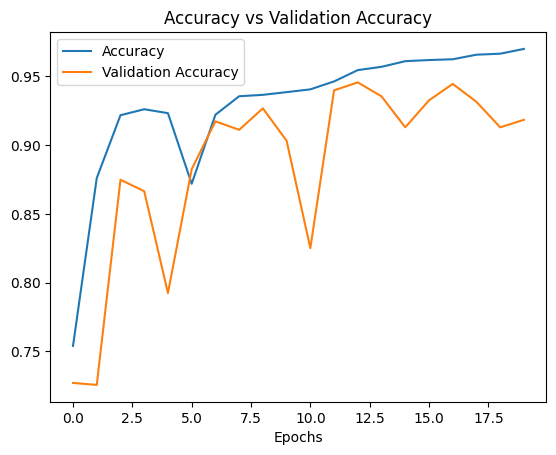

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.legend(['Accuracy', 'Validation Accuracy'])

Text(0.5, 0, 'Epochs')

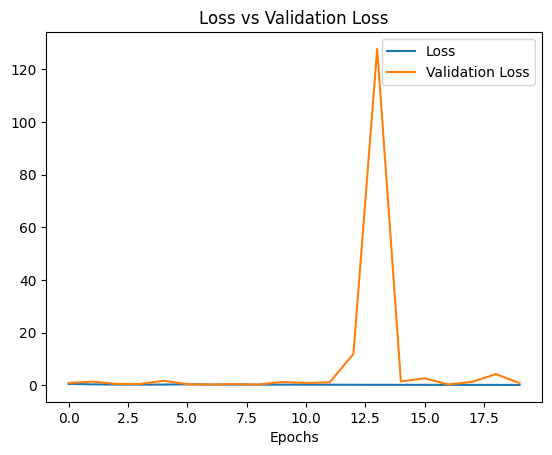

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Validation Loss')
plt.legend(['Loss', 'Validation Loss'])
plt.xlabel('Epochs')

Model Evaluation and Testing

In [23]:
test

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [24]:
train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [25]:
test = test.batch(1)
test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [26]:
model.evaluate(test)

5513/5513 [==============================] - 31s 4ms/step - loss: 0.5759 - accuracy: 0.9195


[0.5758597254753113, 0.9194630980491638]

In [27]:
model.predict(test.take(1))[0][0]

1/1 [==============================] - 10s 10s/step


0.13456611

In [28]:
def parasite_or_not(x):
  if (x<0.5):
    return str('P')
  else:
    return str('U')

1/1 [==============================] - 0s 20ms/step


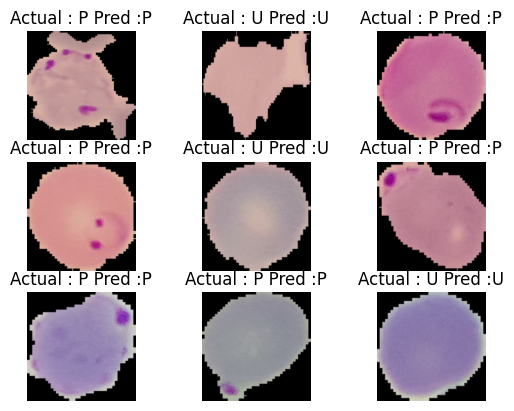

In [29]:
for i,(image,label) in enumerate(test.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0]) #We don't want batch dimension
  plt.title("Actual : " + str(parasite_or_not(label.numpy()[0]))+' Pred :'+str(parasite_or_not(model.predict(image)[0][0])))

  plt.axis('off')

Functional API

In [30]:
func_input = keras.layers.Input(shape = (IMAGE_SIZE,IMAGE_SIZE,3), name = "Input Image")

x = layers.Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(func_input)
x= layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size = 2, strides = 2)(x)

x = layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu')(x)
x= layers.BatchNormalization()(x)
output = layers.MaxPool2D(pool_size = 2, strides = 2)(x)

feature_extractor_model_func = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model_func.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_5 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_6 (Batc  (None, 109, 109, 16

Callable Model

In [31]:
func_input = keras.layers.Input(shape = (IMAGE_SIZE,IMAGE_SIZE,3), name = "Input Image")

x = feature_extractor_model_func(func_input)

x = layers.Flatten()(x)

x = layers.Dense(100,activation = 'relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(200, activation = 'relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(50, activation = 'relu')(x)
x = layers.BatchNormalization()(x)

func_output = layers.Dense(1, activation='sigmoid')(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Function  (None, 54, 54, 16)       1136      
 al)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 46656)             0         
                                                                 
 dense_4 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_7 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_5 (Dense)             (None, 200)               

In [32]:
lenet_model_func.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss = keras.losses.BinaryCrossentropy(),
              metrics = ['accuracy']
              )

In [33]:
history = lenet_model_func.fit(train, validation_data = valid, epochs = 20, verbose = 1)

Epoch 1/20
603/603 [==============================] - 47s 69ms/step - loss: 0.3787 - accuracy: 0.8316 - val_loss: 0.5675 - val_accuracy: 0.8621
Epoch 2/20
603/603 [==============================] - 42s 70ms/step - loss: 0.2012 - accuracy: 0.9318 - val_loss: 0.2125 - val_accuracy: 0.9328
Epoch 3/20
603/603 [==============================] - 43s 72ms/step - loss: 0.1712 - accuracy: 0.9433 - val_loss: 0.3063 - val_accuracy: 0.9172
Epoch 4/20
603/603 [==============================] - 49s 80ms/step - loss: 0.1695 - accuracy: 0.9429 - val_loss: 0.2629 - val_accuracy: 0.9212
Epoch 5/20
603/603 [==============================] - 41s 69ms/step - loss: 0.1428 - accuracy: 0.9535 - val_loss: 0.1924 - val_accuracy: 0.9423
Epoch 6/20
603/603 [==============================] - 40s 67ms/step - loss: 0.1361 - accuracy: 0.9544 - val_loss: 0.3571 - val_accuracy: 0.8348
Epoch 7/20
603/603 [==============================] - 40s 67ms/step - loss: 0.1220 - accuracy: 0.9584 - val_loss: 0.1805 - val_accuracy:

Model Subclassing

In [34]:
class FeatureExtractor(Layer):
  def __init__(self,filters,kernel_size,strides,padding,activation,pool_size):
    super(FeatureExtractor,self).__init__()

    self.conv_1 = layers.Conv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = padding, activation=activation)
    self.batch_1 = layers.BatchNormalization()
    self.pool_1 = layers.MaxPool2D(pool_size = pool_size, strides = 2*strides)

    self.conv_2 = layers.Conv2D(filters = filters*2 , kernel_size=kernel_size, strides=strides, padding=padding, activation=activation)
    self.batch_2 = layers.BatchNormalization()
    self.pool_2 = layers.MaxPool2D(pool_size = pool_size, strides = 2*strides)

  def call(self,x,training):
     x = self.conv_1(x)
     x = self.batch_1(x)
     x = self.pool_1(x)

     x = self.conv_2(x)
     x = self.batch_2(x)
     x = self.pool_2(x)

     return x

In [35]:
feature_subclass = FeatureExtractor(8,3,1,'valid','relu',2)
func_input = keras.layers.Input(shape = (IMAGE_SIZE,IMAGE_SIZE,3), name = "Input Image")

x = feature_subclass(func_input)

x = layers.Flatten()(x)

x = layers.Dense(100,activation = 'relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(200, activation = 'relu')(x)
x = layers.BatchNormalization()(x)

x = layers.Dense(50, activation = 'relu')(x)
x = layers.BatchNormalization()(x)

func_output = layers.Dense(1, activation='sigmoid')(x)

lenet_model_subclass = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_subclass.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (FeatureE  (None, 54, 54, 16)       1488      
 xtractor)                                                       
                                                                 
 flatten_2 (Flatten)         (None, 46656)             0         
                                                                 
 dense_8 (Dense)             (None, 100)               4665700   
                                                                 
 batch_normalization_12 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 dense_9 (Dense)             (None, 200)               

In [36]:
class LenetModel(Model):
  def __init__(self):
    super(LenetModel,self).__init__()

    self.feature_extractor = FeatureExtractor(8,3,1,'valid','relu',2)
    self.flatten = layers.Flatten()

    self.dense_1 = layers.Dense(100,activation = 'relu')
    self.batch_1 = layers.BatchNormalization()

    self.dense_2 = layers.Dense(200,activation = 'relu')
    self.batch_2 = layers.BatchNormalization()

    self.dense_3 = layers.Dense(50,activation = 'relu')
    self.batch_3 = layers.BatchNormalization()

    self.dense_4 = layers.Dense(1,activation = 'sigmoid')

  def call(self,x,training):
    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense_1(x)
    x = self.batch_1(x)
    x = self.dense_2(x)
    x = self.batch_2(x)
    x = self.dense_3(x)
    x = self.batch_3(x)
    x = self.dense_4(x)

    return x

lenet_model_subclass = LenetModel()
lenet_model_subclass(tf.zeros([1,224,224,3]))
lenet_model_subclass.summary()

Model: "lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_1 (Featur  multiple                 1488      
 eExtractor)                                                     
                                                                 
 flatten_3 (Flatten)         multiple                  0         
                                                                 
 dense_12 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_17 (Bat  multiple                 400       
 chNormalization)                                                
                                                                 
 dense_13 (Dense)            multiple                  20200     
                                                                 
 batch_normalization_18 (Bat  multiple                 

Custom Layers

In [37]:
class CustomDense(Layer):
  def __init__(self,output_units,activation):
    super(CustomDense,self).__init__()
    self.output_units = output_units
    self.activation = activation

  def build(self, input_features_shape):
    self.w = self.add_weight(shape = (input_features_shape[-1],self.output_units), trainable = True, initializer = 'random_normal')
    self.b = self.add_weight(shape = (self.output_units,), trainable = True, initializer = 'random_normal')

  def call(self,input_features):
    if (self.activation=='relu'):
      return tf.nn.relu(tf.matmul(input_features,self.w) + self.b)
    elif (self.activation=='sigmoid'):
      return tf.math.sigmoid(tf.matmul(input_features,self.w) + self.b)
    else:
      return tf.matmul(input_features,self.w) + self.b

In [38]:
lenet_model_custom = tf.keras.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)),

    layers.Conv2D(filters = 5, kernel_size = 5, strides = 1 , padding = "valid", activation = 'sigmoid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides = 2),

    layers.Conv2D(filters =10, kernel_size = 5, strides = 1 , padding = "valid", activation = 'sigmoid'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2), strides = 2),

    layers.Flatten(),

    CustomDense(100,activation = 'relu'),
    layers.BatchNormalization(),

    CustomDense(200, activation = 'relu'),
    layers.BatchNormalization(),

    CustomDense(50, activation = 'relu'),
    layers.BatchNormalization(),

    CustomDense(1, activation='sigmoid'),
])

In [39]:
lenet_model_custom.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 220, 220, 5)       380       
                                                                 
 batch_normalization_20 (Bat  (None, 220, 220, 5)      20        
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 110, 110, 5)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 106, 106, 10)      1260      
                                                                 
 batch_normalization_21 (Bat  (None, 106, 106, 10)     40        
 chNormalization)                                                
                                                      

In [40]:
metrics = [TrueNegatives(name='tn'),TruePositives(name='tp'),FalseNegatives(name='fn'),FalsePositives(name='fp'),Precision(name='precision'),BinaryAccuracy(name='accuracy'),Recall(name='recall'),AUC(name='auc')]

In [41]:
from keras.api._v2.keras.losses import BinaryCrossentropy
lenet_model_custom.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.01),
                           loss = BinaryCrossentropy(),
                           metrics = metrics)

In [42]:
lenet_model_custom.fit(train,validation_data = valid, epochs = 20, verbose = 1)

Epoch 1/20
603/603 [==============================] - 48s 70ms/step - loss: 0.4151 - tn: 7983.0000 - tp: 7520.0000 - fn: 2113.0000 - fp: 1674.0000 - precision: 0.8179 - accuracy: 0.8037 - recall: 0.7806 - auc: 0.8907 - val_loss: 5.6692 - val_tn: 218.0000 - val_tp: 1373.0000 - val_fn: 10.0000 - val_fp: 1154.0000 - val_precision: 0.5433 - val_accuracy: 0.5775 - val_recall: 0.9928 - val_auc: 0.6313
Epoch 2/20
603/603 [==============================] - 51s 85ms/step - loss: 0.2542 - tn: 8758.0000 - tp: 8783.0000 - fn: 852.0000 - fp: 897.0000 - precision: 0.9073 - accuracy: 0.9093 - recall: 0.9116 - auc: 0.9582 - val_loss: 0.7919 - val_tn: 1130.0000 - val_tp: 1335.0000 - val_fn: 54.0000 - val_fp: 236.0000 - val_precision: 0.8498 - val_accuracy: 0.8947 - val_recall: 0.9611 - val_auc: 0.9394
Epoch 3/20
603/603 [==============================] - 49s 82ms/step - loss: 0.1853 - tn: 8960.0000 - tp: 9198.0000 - fn: 438.0000 - fp: 694.0000 - precision: 0.9298 - accuracy: 0.9413 - recall: 0.9545 - a

Model predicts negative and you have parasite - False Negative

Model predicts positive and you don't have parasite - False Positive

Model predicts negative and you don't have parasite - True Negative

Model predicts positive and you have parasite - True Positive

Confusion matrix = [[TN FP],
                    [FN TP]]

Generally choose model which minimizes the false negatives.

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)
Accuracy = (TN+TP)/(TN+TP+FN+FP)
F1-Score = 2* Precision * Recall/(Precision+recall)
Specificity = TN/(TN+FP)

ROC Curve is Recall vs (1-Specificity) curve

In [43]:
test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [44]:
lenet_model_custom.evaluate(test,verbose = 1)

5513/5513 [==============================] - 39s 5ms/step - loss: 0.3566 - tn: 2471.0000 - tp: 2685.0000 - fn: 71.0000 - fp: 286.0000 - precision: 0.9037 - accuracy: 0.9352 - recall: 0.9742 - auc: 0.9652


[0.3566092252731323,
 2471.0,
 2685.0,
 71.0,
 286.0,
 0.9037361145019531,
 0.9352439641952515,
 0.9742380380630493,
 0.965200662612915]

Confusion Matrix

In [45]:
labels = []
input = []
for x,y in test.as_numpy_iterator():
  labels.append(y)
  input.append(x)

labels = np.array([i[0] for i in labels])
labels

array([1, 0, 1, ..., 1, 0, 0])

In [46]:
print(np.array(input).shape)
print(np.array(input)[:,0,...].shape)

(5513, 1, 224, 224, 3)
(5513, 224, 224, 3)
